In [1]:
import numpy as np
import random as rn
import os 
from numpy.random import randint
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colorbar
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import NoReturn, Text
import warnings
import time
# import pyvista as pv
# from scipy.signal import find_peaks
from celluloid import Camera
from datetime import datetime

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)
# pv.set_plot_theme("document")
%matplotlib inline

from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
from geovoronoi import voronoi_regions_from_coords
from geovoronoi import polygon_lines_from_voronoi
import shapely
from shapely.geometry import Point
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon
from descartes import PolygonPatch
import numpy as np
from shapely.geometry.polygon import LinearRing, Polygon
# import pyvista as pv
from matplotlib import cm
import datetime
import snakeviz
plt.style.use('plot_style.txt')


In [2]:
#import local scripts
from Agent import Agent
from Model import Model
from Grid import Grid

In [3]:
## Set seed for random generation
def seed_everything(seed : int) -> NoReturn :
    """To set the see for all potential random number usages. If you are using 
    any other package which might use seed for random generation add it here"""
    rn.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #tf.random.set_seed(seed)  ##uncomment if you are using tensorflow
    
SEED = 123123
seed_everything(SEED)

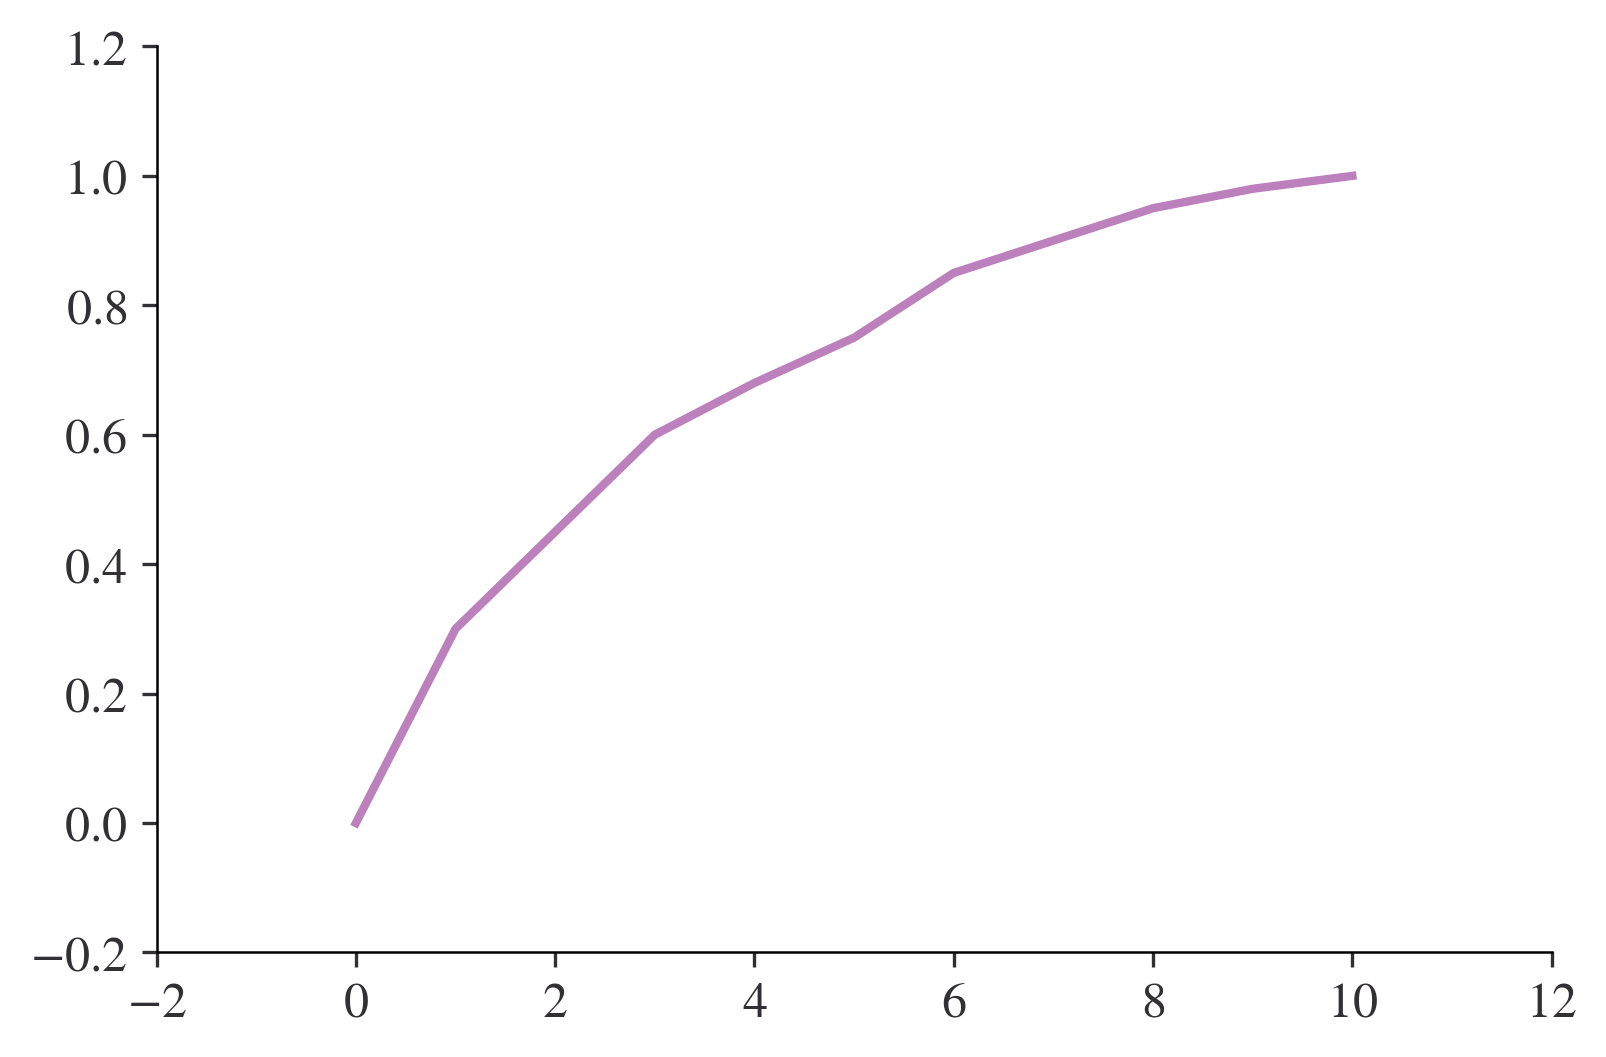

In [4]:
F_points_target = np.array([0, 0.7, 0.85, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 0.999, 1])
F_points_target = np.array([0, 0.3, 0.45, 0.6, 0.68, 0.75, 0.85, 0.9, 0.95, 0.98, 1])

plt.plot(F_points_target)

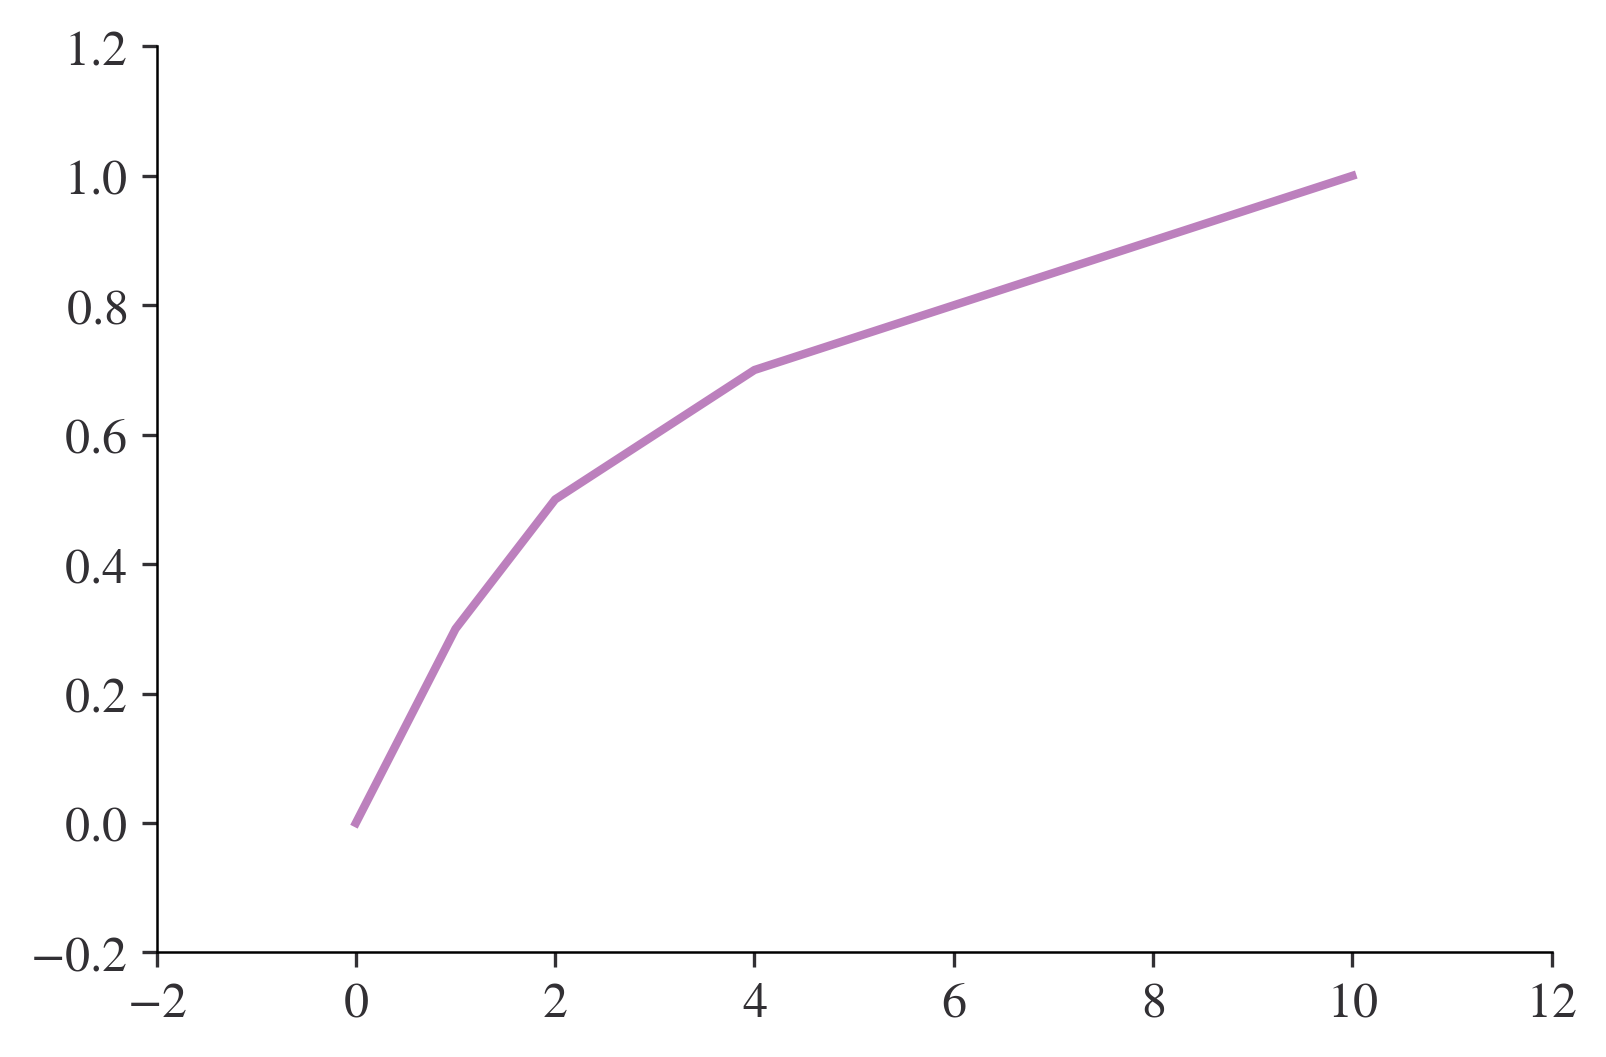

In [5]:
### set parameters 
TURNS = 25
RATIOTRACKEDAGENTS = 1.
all_vals_len = 200*100

# set up TI_zone env
# generate 2D mesh
x = np.arange(0,200+1,1,)
y = np.arange(0,100+1,1)
x_grid, y_grid = np.meshgrid(x,y)
#get cell centers of mesh
x_cell_center = x_grid[:-1,:-1]+0.5
y_cell_center = y_grid[:-1,:-1]+0.5
TI_zones = []
for y in range(x_cell_center.shape[0]):
    for x in range(len(x_cell_center[1])):
        if 70 <= x_cell_center[y,x] <=130:
            TI_zones.append(1)
        else:
            TI_zones.append(0)
TI_zones = np.array(TI_zones)
TI_zones = TI_zones.reshape((200,100,1))

# create curve and save resultign desired LC
Phi_points_target = np.linspace(0, 1, num=11, endpoint=True)
F_points_target = np.array([0, 0.3, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1])
# F_points_target = np.array([0, 0.3, 0.45, 0.6, 0.68, 0.75, 0.8, 0.85, 0.9, 0.95, 1])
# F_points_target = np.array([0, 0.7, 0.85, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 0.999, 1])
# F_points_target = np.array([0, 0.3, 0.45, 0.6, 0.68, 0.75, 0.85, 0.9, 0.95, 0.98, 1])

plt.plot(F_points_target)
output_folder = str(datetime.datetime.today().replace(microsecond= 0, second = 0).strftime("%Y_%m_%d_%H_%M"))

In [6]:
t1 = time.time()

model = Model(env = TI_zones, 
              number_of_turns=TURNS, number_of_starting_agents = 25,new_agent_every_n_turns = 150,max_number_agents = 150,
              ratio_of_tracked_agents = 1.,number_training_image_zones = 2, number_training_images_per_zone = 20,output_folder = output_folder,
              Phi_points_target=Phi_points_target,F_points_target=F_points_target,max_number_of_position_tests = 10 ,n_processes = None,neighbourhood_radius = 10, neighbourhood_search_step_size = 10 ,
             boundary_rule_weight = 0.0,misfit_rule_weight = 1.0,TI_zone_rule_weight = 0.0)

model.run()
print("Simulation took {0:2.2f} seconds".format(time.time()-t1))
test_df =model.get_final_results()
print(test_df.head(20))

Shape of your environment: (200, 100, 1)
=======loading training images=========
Training images loaded! -  took 23.89 seconds
=======Initiating grid=========
Grid initiated! -  took 0.01 seconds
generated new agent
generated new agent
generated new agent
generated new agent
generated new agent
generated new agent
generated new agent
generated new agent
generated new agent
generated new agent
generated new agent
generated new agent
generated new agent
generated new agent
generated new agent
generated new agent
generated new agent
generated new agent
generated new agent
generated new agent
generated new agent
generated new agent
generated new agent
generated new agent
generated new agent
Misfit: 0.15748214721679688
=======Turn 0========
Moving agents done                  
Generating agents done              
=======Turn 1========
Moving agents done                  
Generating agents done              
=======Turn 2========
Moving agents done                  
Generating agents done   

In [8]:
# # check runtimes of different bits of code 
# %load_ext snakeviz
# %%snakeviz
# model.run()\

In [7]:
tracker = model.get_all_tracks()

ValueError: cannot copy sequence with size 10 to array axis with dimension 8

In [10]:
def get_all_tracks(model):
    """ Extract the tracking path of all the agents during the simulation in numpy.array of shape (number of agent, number of turns, 3 coordinates) """
    track_file = np.empty((model.current_id+1, ((model.number_of_turns)*(model.number_of_starting_agents+1 + model.current_id+1 -(model.number_of_starting_agents+1))+1)  , 10))
    track_file[:] = np.nan
    for agent in model.active_agents:
        if agent.isTracked:
            track_file[agent.id, agent.start_iteration:, :] = agent.track
    for agent in model.dead_agents:
        if agent.isTracked:
            track_file[agent.id, agent.start_iteration:, :] = agent.track
    return track_file

In [11]:
def get_all_tracks(model):
    """ Extract the tracking path of all the agents during the simulation in numpy.array of shape (number of agent, number of turns, 3 coordinates) """
    track_file = np.empty((model.current_id+1, model.number_of_turns+1  , 10))
    track_file[:] = np.nan
    for agent in model.active_agents:
        if agent.isTracked:
            track_file[agent.id, agent.start_iteration:, :] = agent.track
    for agent in model.dead_agents:
        if agent.isTracked:
            track_file[agent.id, agent.start_iteration:agent.dead_iteration, :] = agent.track
    return track_file

In [12]:
tracker = get_all_tracks(model)
# tracker = model.get_all_tracks()


In [13]:
tracker[:][1]

array([[1.30000000e+01, 9.80000000e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.00000000e+00, 1.57482147e-01, 0.00000000e+00,
                   nan,            nan],
       [2.30000000e+01, 9.80000000e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.40000000e+01, 2.07166865e-01, 2.07166865e-01,
        0.00000000e+00, 0.00000000e+00],
       [2.30000000e+01, 9.80000000e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.40000000e+01, 9.47083607e-02, 9.47083607e-02,
        0.00000000e+00, 0.00000000e+00],
       [3.30000000e+01, 9.80000000e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+01, 8.09439942e-02, 8.09439942e-02,
        0.00000000e+00, 0.00000000e+00],
       [2.30000000e+01, 9.80000000e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+01, 7.74648115e-02, 7.74648115e-02,
        0.00000000e+00, 0.00000000e+00],
       [2.30000000e+01, 8.80000000e+01, 0.00000000e+00, 0.00000000e+00,
   

In [14]:
TI_zone_assigned=[]
for turns in range(len(tracker[0])):
    agent_pos = []
    for agent_id in range(model.current_id+1):
        agent_pos.append(tracker[agent_id][turns][3])
    
    TI_zone_assigned.append(agent_pos)
TI_zone_assigned = np.array(TI_zone_assigned)

In [15]:
# adjust format 
iteration=[]
misfit = []
best_quality = []
for turns in range(len(tracker[0])):
    agent_pos = []
    for agent_id in range(model.current_id+1):
        agent_pos.append(tracker[agent_id][turns][0:7])
        misfit.append(tracker[agent_id][turns][6])
        best_quality.append(tracker[agent_id][turns][7])

    iteration.append(agent_pos)
iteration = np.array(iteration)


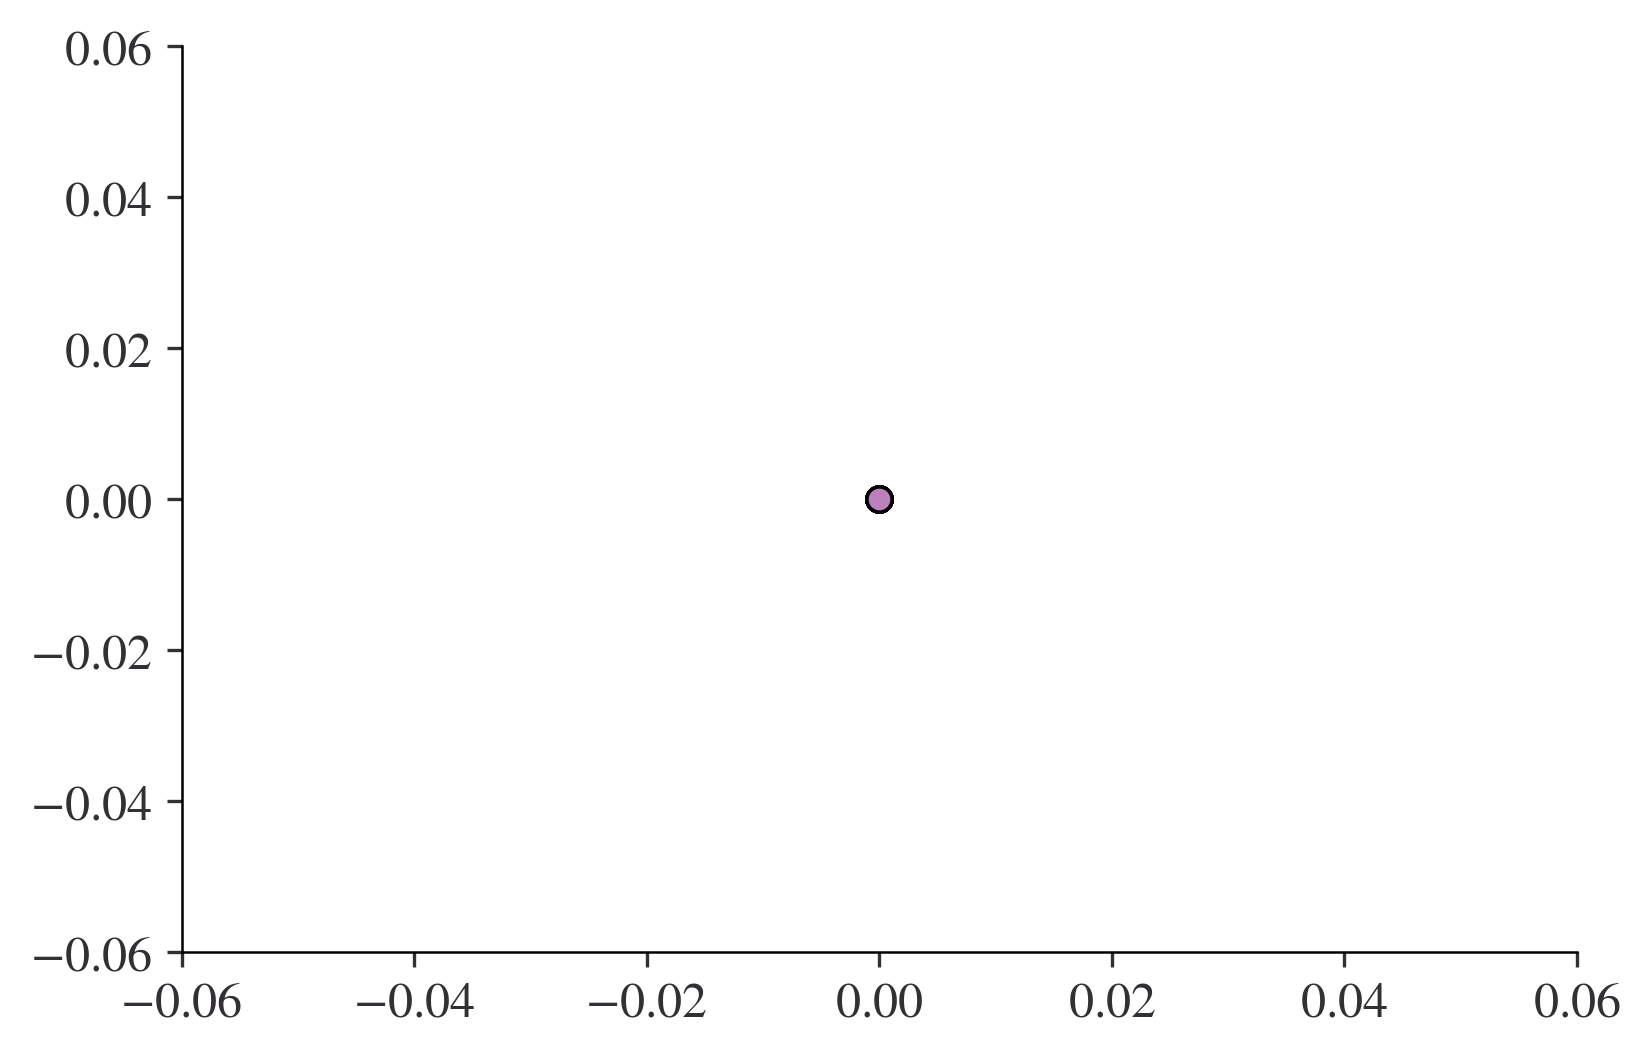

In [16]:
plt.scatter(tracker[1][0:100,8],tracker[4][0:100,8])

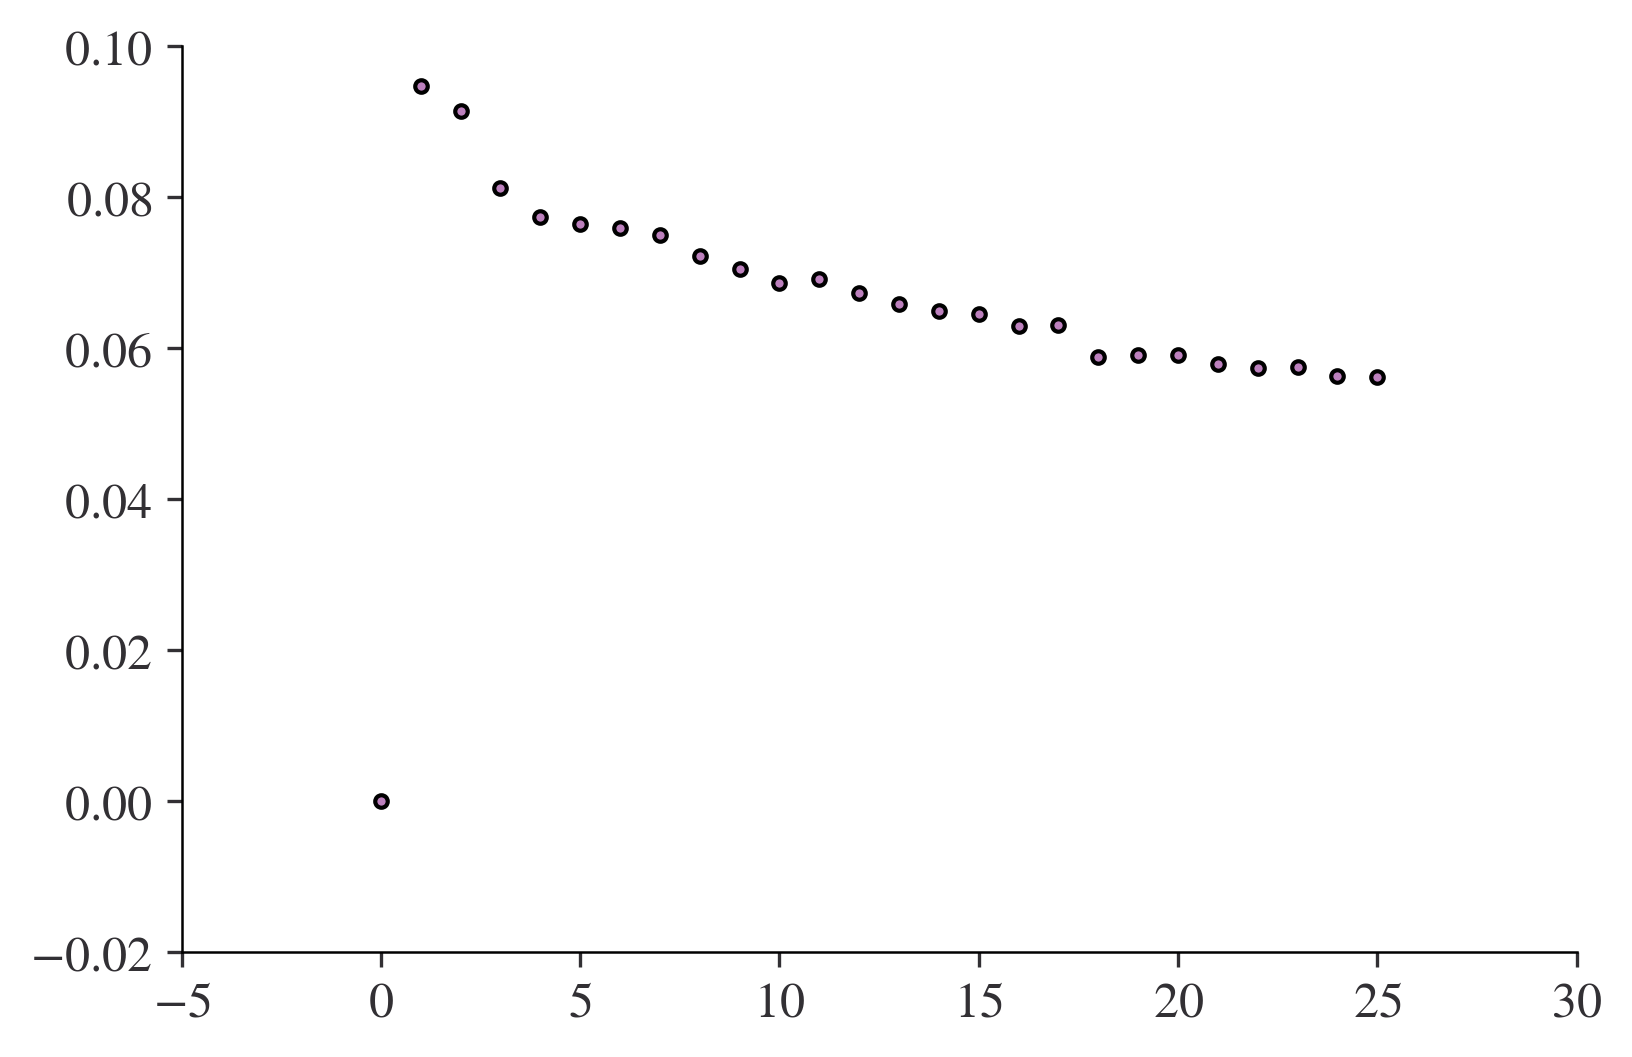

In [17]:
plt.plot(tracker[24][:,7],".")

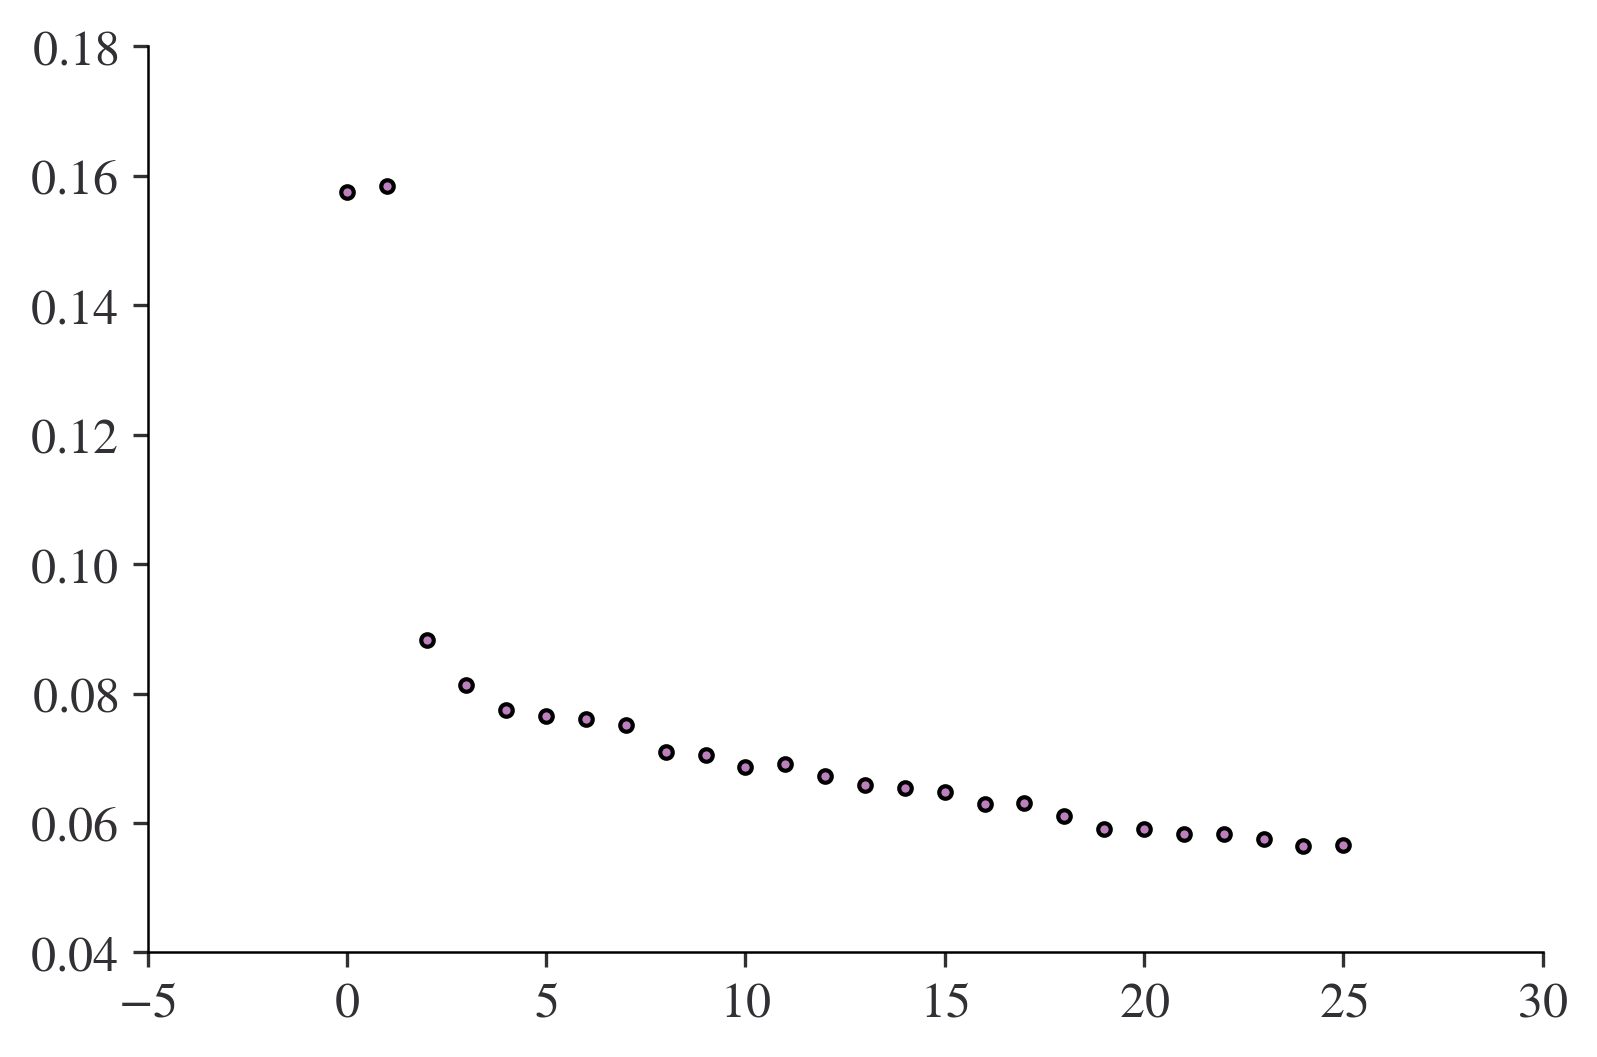

In [27]:
plt.plot(tracker[3][0:100,6],".")

Text(0, 0.5, 'best_quality')

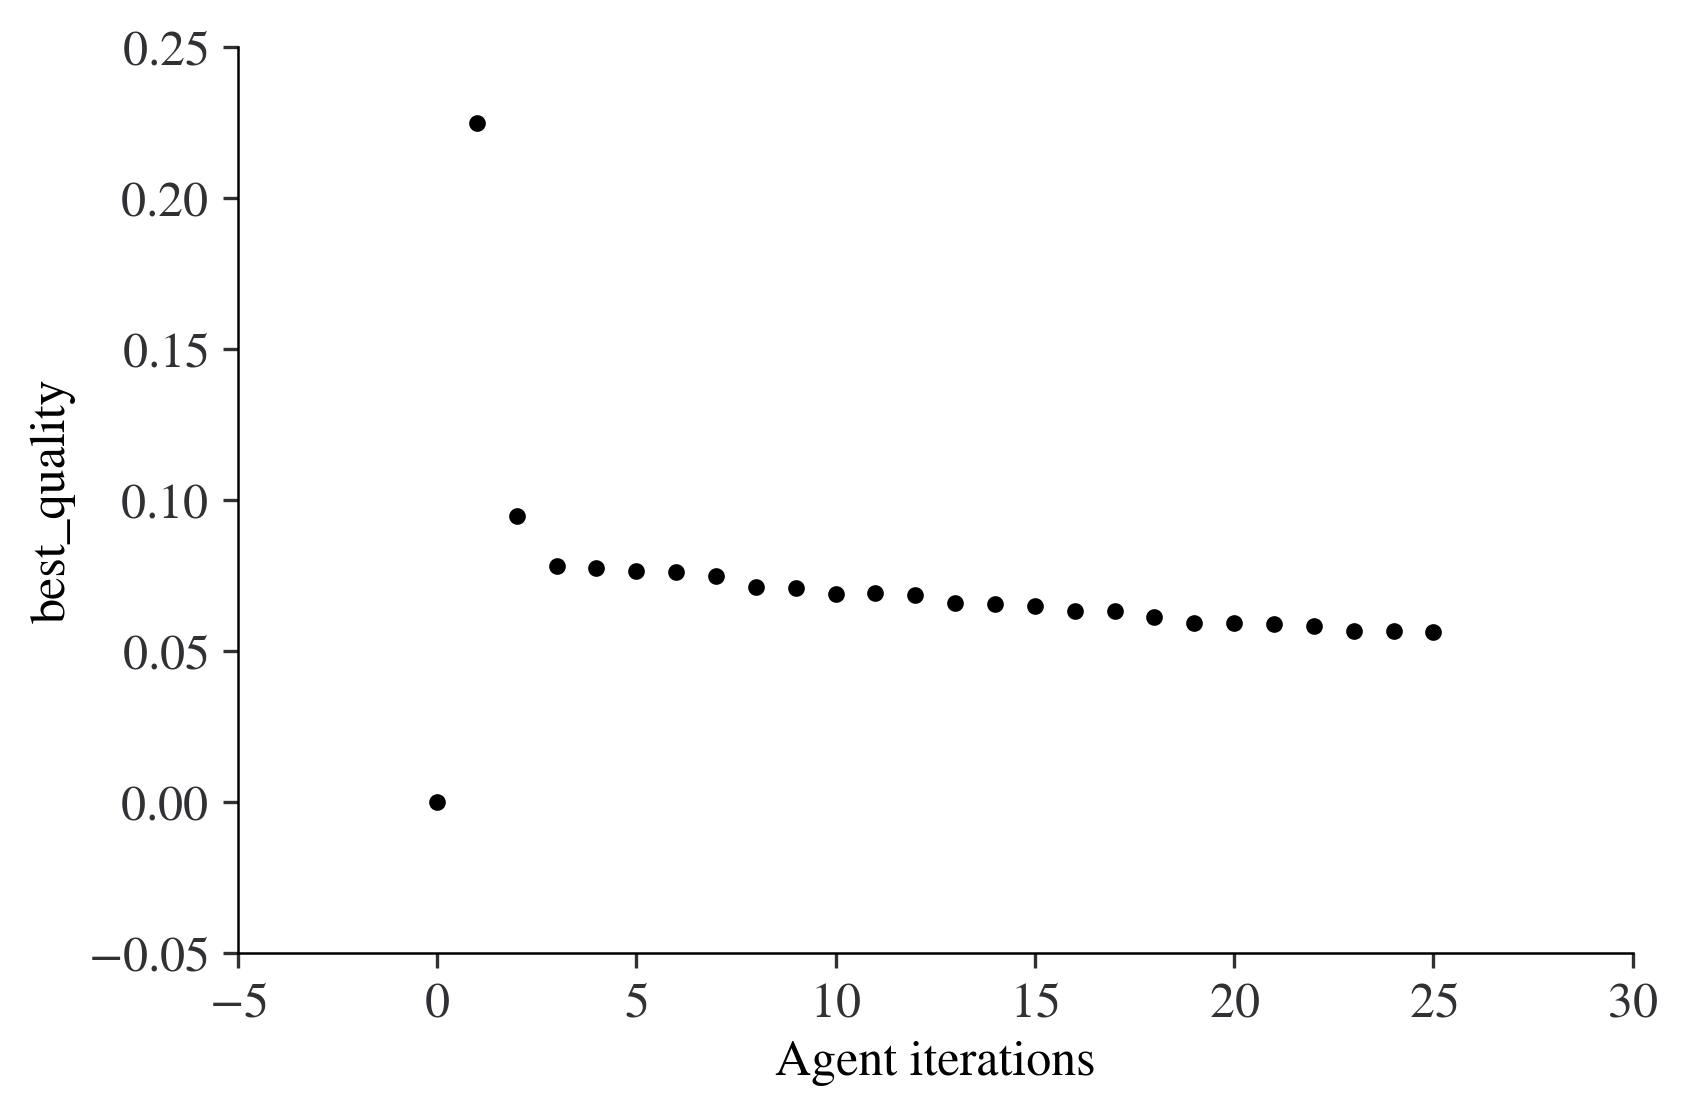

In [18]:
best_quality_cut = best_quality[::model.number_of_starting_agents]
plt.plot(best_quality_cut,".",color = "black")
# plt.xlim(0,len(best_quality_cut))
# plt.ylim(0,0.4)
plt.xlabel("Agent iterations")
plt.ylabel("best_quality")
# plt.savefig('misfit_results.png', bbox_inches='tight',dpi = 300)

<IPython.core.display.Javascript object>


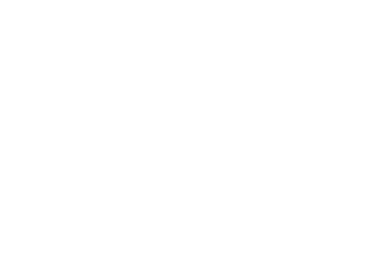

Text(0, 0.5, 'misfit')

<IPython.core.display.Javascript object>


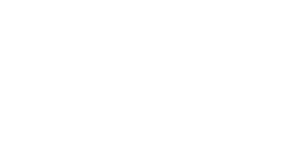

In [83]:
misfit_cut = misfit[::model.number_of_starting_agents]
plt.plot(misfit_cut,".",color = "black")
# plt.xlim(0,len(best_quality_cut))
# plt.ylim(0,0.4)
plt.xlabel("Agent iterations")
plt.ylabel("misfit")
# plt.savefig('misfit_results.png', bbox_inches='tight',dpi = 300)

In [84]:
best_quality_cut

[0.0,
 0.68,
 0.48,
 0.68,
 0.68,
 0.48,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [19]:
misfit_cut = misfit[::50]
misfit_cut.index(min(misfit_cut))

12

In [20]:
max(misfit_cut)

0.15748214721679688

In [32]:
N = 50
# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
viridis = cm.get_cmap('jet', 5)
viridis(3)

(1.0, 0.5925925925925927, 0.0, 1.0)

In [33]:
grid = Polygon([(0, 0), (0, 100), (200, 100), (200, 0)])


(0.0, 100.0)

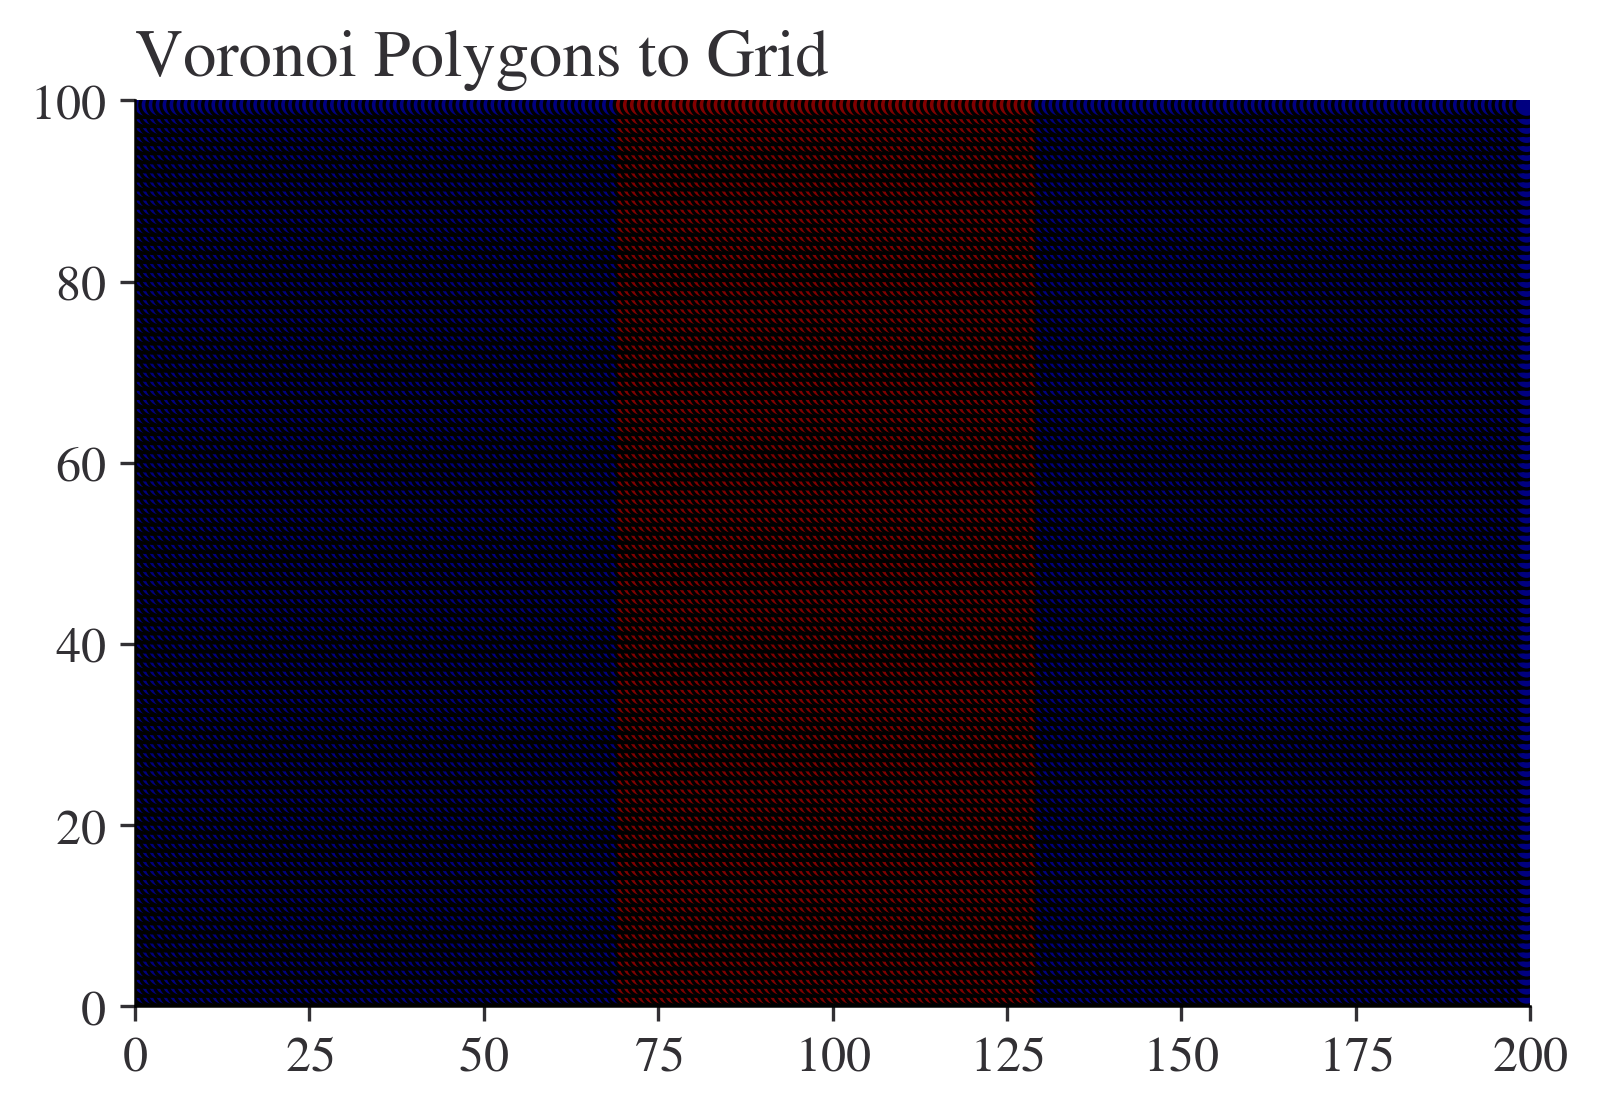

In [34]:
# generate 2D mesh
x = np.arange(0,200+1,1,)
y = np.arange(0,100+1,1)
x_grid, y_grid = np.meshgrid(x,y)
# get cell center
x_cell_center = x_grid[:-1,:-1]+0.5
y_cell_center = y_grid[:-1,:-1]+0.5
cell_center_which_polygon = np.zeros(len(x_cell_center.flatten()))
which_TI_zone = np.zeros(len(x_cell_center.flatten()))
# array to assign polygon to cell id
all_cell_center = np.column_stack((x_cell_center.flatten(),y_cell_center.flatten(),cell_center_which_polygon,which_TI_zone))
plt.scatter(x_cell_center,y_cell_center, c = TI_zones,cmap=viridis)
plt.title("Voronoi Polygons to Grid")
plt.xlim([0,200])
plt.ylim([0,100])

In [35]:
# in what voronoi polygon do cell centers plot
for i in range(len(all_cell_center)):
    for voronoi_polygon_id in range(len(poly_shapes)):
        
        polygon = poly_shapes[voronoi_polygon_id]
        cell_id = Point(all_cell_center[i,0],all_cell_center[i,1])
        
        if polygon.intersects(cell_id):
            all_cell_center[i,2] = voronoi_polygon_id

plt.scatter(x_cell_center,y_cell_center, c = all_cell_center[:,2])
plt.title("Voronoi Polygons to Grid")
plt.xlim([0,200])
plt.ylim([0,100])


NameError: name 'poly_shapes' is not defined

In [36]:
color_steps = np.linspace(0.15,1,20)
cmap_blues = matplotlib.cm.get_cmap('Blues')
cmap_greens = matplotlib.cm.get_cmap('Greens')
cmap_reds = matplotlib.cm.get_cmap('Reds')
color_greens = []
color_blues = []
color_reds = []

for i in range(len(color_steps)):
    color_blues.append(cmap_blues(color_steps[i]))
    color_greens.append(cmap_greens(color_steps[i]))
    color_reds.append(cmap_reds(color_steps[i]))

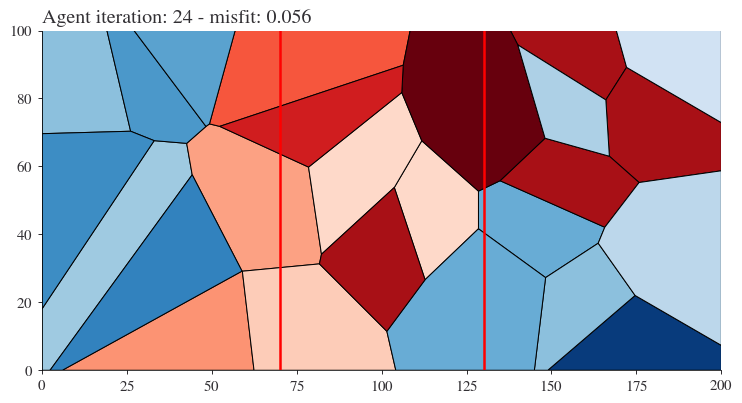

In [37]:
%matplotlib inline
iter_to_display = 24

# extract voronoi point and TI_zone affiliated with them
voronoi_points = np.vstack((iteration[iter_to_display][:,0],iteration[iter_to_display][:,1])).T
voronoi_points = voronoi_points[~np.isnan(voronoi_points).any(axis=1)]

zone = iteration[iter_to_display][:,5]
zone = zone[~np.isnan(zone)]
TI_zone_used = iteration[iter_to_display][:,4]
TI_zone_used = TI_zone_used[~np.isnan(TI_zone_used)]

# zone[-1]=zone[-2]
# get voronoi regions
poly_shapes, pts, poly_to_pt_assignments = voronoi_regions_from_coords(voronoi_points, grid)
# get polygons back into correct order with zip and sorted
poly_to_point = []
for i in range(len(poly_to_pt_assignments)):
    poly_to_point.append(poly_to_pt_assignments[i][0])
zipped_lists = zip(poly_to_point,poly_shapes)
sorted_zipped_lists = sorted(zipped_lists)
poly_shapes = [element for _, element in sorted_zipped_lists]
fig = plt.figure(1, figsize=(10,5), dpi=90)

ax = fig.add_subplot(111)
for j in range(len(poly_shapes)):
    if TI_zone_used[j] == 0:
        color = color_blues
    else:
        color = color_reds
    TI_id = int(zone[j])
    ring_patch = PolygonPatch(poly_shapes[j], facecolor =  color[TI_id])
    ax.add_patch(ring_patch)
    ax.set_title('Agent iteration: {} - misfit: {}'.format(iter_to_display,np.round(np.nanmin(iteration[iter_to_display][:,6]),3)))
    xrange = [0, 200]
    yrange = [0, 100]
    ax.set_xlim(*xrange)
    ax.set_ylim(*yrange)
    ax.set_aspect(1)
ax.axvline(x = 70, color = "r", linestyle = "-")
ax.axvline(x = 130, color = "r", linestyle = "-")

xs = [pts.x for pts in pts]
ys = [pts.y for pts in pts]
plt.savefig('iter_900_TIs.png', bbox_inches='tight',dpi = 300)
ax.scatter(xs,ys)
plt.show()

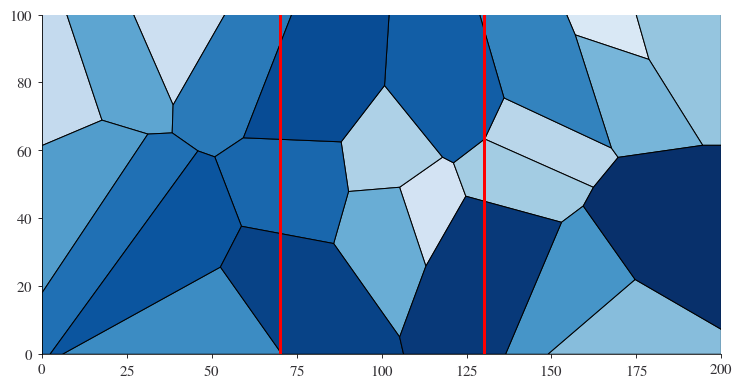

In [38]:
# color by polygon size
%matplotlib inline
iter_to_display = 10

color_steps = np.linspace(0.15,1,len(poly_shapes))
cmap_blues = matplotlib.cm.get_cmap('Blues')
color_blues = []
for i in range(len(color_steps)):
    color_blues.append(cmap_blues(color_steps[i]))

# extract voronoi point and TI_zone affiliated with them
voronoi_points = np.vstack((iteration[iter_to_display][:,0],iteration[iter_to_display][:,1])).T
voronoi_points = voronoi_points[~np.isnan(voronoi_points).any(axis=1)]

zone = iteration[iter_to_display][:,5]
zone = zone[~np.isnan(zone)]
TI_zone_used = iteration[iter_to_display][:,4]
TI_zone_used = TI_zone_used[~np.isnan(TI_zone_used)]

# zone[-1]=zone[-2]
# get voronoi regions
poly_shapes, pts, poly_to_pt_assignments = voronoi_regions_from_coords(voronoi_points, grid)
# get polygons back into correct order with zip and sorted
poly_to_point = []
for i in range(len(poly_to_pt_assignments)):
    poly_to_point.append(poly_to_pt_assignments[i][0])
zipped_lists = zip(poly_to_point,poly_shapes)
sorted_zipped_lists = sorted(zipped_lists)
poly_shapes = [element for _, element in sorted_zipped_lists]

size_polygon = []
for i in range(len(poly_shapes)):
    size_polygon.append(poly_shapes[i].area)
    
poly_shapes_size_sorted  = [x for _, x in sorted(zip(size_polygon, poly_shapes))]


color_steps = np.linspace(0.15,1,len(poly_shapes))
cmap_blues = matplotlib.cm.get_cmap('Blues')
color_blues = []
for i in range(len(color_steps)):
    color_blues.append(cmap_blues(color_steps[i]))

fig = plt.figure(1, figsize=(10,5), dpi=90)

ax = fig.add_subplot(111)
for j in range(len(poly_shapes)):
    color = color_blues
    ring_patch = PolygonPatch(poly_shapes_size_sorted[j], facecolor =  color[j])
    ax.add_patch(ring_patch)
#     ax.set_title('Voronoi tesselation - Iteration {} - misfit {}'.format(iter_to_display,np.round(np.nanmin(iteration[iter_to_display][:,6]),3)))
    xrange = [0, 200]
    yrange = [0, 100]
    ax.axvline(x = 70, color = "r", linestyle = "-")
    ax.axvline(x = 130, color = "r", linestyle = "-")

    ax.set_xlim(*xrange)
    ax.set_ylim(*yrange)
    ax.set_aspect(1)


In [102]:
%matplotlib notebook
%matplotlib notebook

<IPython.core.display.Javascript object>


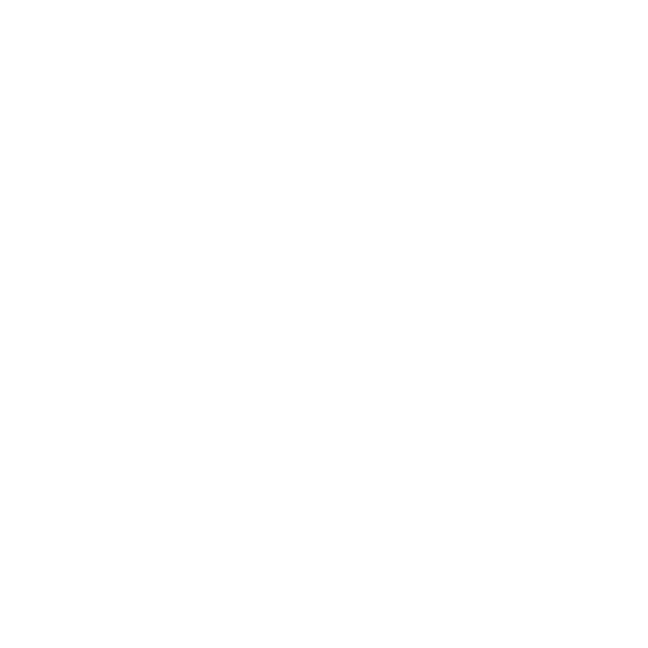

<IPython.core.display.Javascript object>


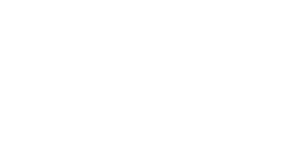

In [103]:
fig = plt.figure(figsize = (10,10))
camera = Camera(fig)
for i in range(len(tracker[0])):
    # extract voronoi points and TI_zone affiliated with them
    voronoi_points = np.vstack((iteration[i][:,0],iteration[i][:,1])).T
    voronoi_points = voronoi_points[~np.isnan(voronoi_points).any(axis=1)]

#     zone = iteration[i][:,5]
#     zone = zone[~np.isnan(zone)]
    
    zone = iteration[i][:,3]
    zone = zone[~np.isnan(zone)]
    TI_zone_used = iteration[i][:,4]
    TI_zone_used = TI_zone_used[~np.isnan(TI_zone_used)]

    # get voronoi regions
    poly_shapes, pts, poly_to_pt_assignments = voronoi_regions_from_coords(voronoi_points, grid)
    # get polygons back into correct order with zip and sorted
    poly_to_point = []
    for k in range(len(poly_to_pt_assignments)):
        poly_to_point.append(poly_to_pt_assignments[k][0])
    zipped_lists = zip(poly_to_point,poly_shapes)
    sorted_zipped_lists = sorted(zipped_lists)
    poly_shapes = [element for _, element in sorted_zipped_lists]
    fig = plt.figure(1, figsize=(5,5), dpi=90)
#     color = ["Green","Yellow","Blue","Azure","Red","Black","Brown","White","Ivory","Teal","Silver","Gray","Purple","Orange","Maroon","Lime","Aquamarine","Coral","Wheat","Crimson"]
#     color = 100*np.random.randint(len(voronoi_points))
    viridis = cm.get_cmap('jet', 12)

    ax = fig.add_subplot(111)
    for j in range(len(poly_shapes)):
        if TI_zone_used[j] == 0:
            color = color_blues
        else:
            color = color_reds
        TI_id = zone[j]
        ring_patch = PolygonPatch(poly_shapes[j], facecolor =  color[int(TI_id)])
        ax.add_patch(ring_patch)
        ax.set_title('Voronoi tesselation iteration')
        xrange = [0, 200]
        yrange = [0, 100]
        ax.set_xlim(*xrange)
        ax.set_ylim(*yrange)
        ax.set_aspect(1)
        xs = [pts.x for pts in pts]
        ys = [pts.y for pts in pts]

        ax.scatter(xs,ys)
# plt.show()

    # plt.xlim([0,10])
    # plt.ylim([0,10])
    camera.snap()
animation = camera.animate()

In [105]:
### Save the animated plot as GIF ###

import matplotlib.animation as mpl_anim

# Set up formatting for the movie files
Writer = mpl_anim.PillowWriter
writer = Writer(fps=5, metadata=dict(artist='Steffens'), bitrate=1800)


animation.save('./figures/TI_zone_only_boundary_move2.gif', writer=writer)

<IPython.core.display.Javascript object>


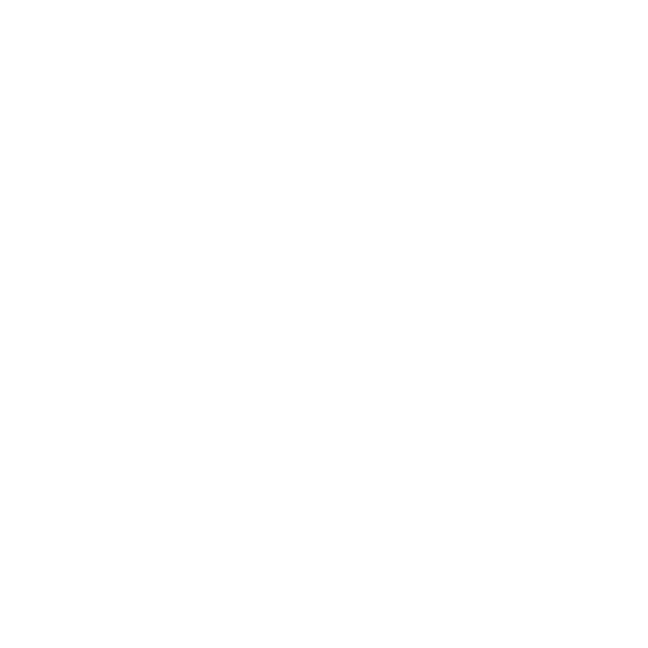

<IPython.core.display.Javascript object>


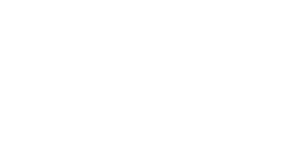

In [70]:
fig = plt.figure(figsize = (10,10))
camera = Camera(fig)
for i in range(len(tracker[0])):
    # extract voronoi points and TI_zone affiliated with them
    voronoi_points = np.vstack((iteration[i][:,0],iteration[i][:,1])).T
    voronoi_points = voronoi_points[~np.isnan(voronoi_points).any(axis=1)]
   
    zone = iteration[i][:,3]
    zone = zone[~np.isnan(zone)]
    TI_zone_used = iteration[i][:,4]
    TI_zone_used = TI_zone_used[~np.isnan(TI_zone_used)]

    # get voronoi regions
    poly_shapes, pts, poly_to_pt_assignments = voronoi_regions_from_coords(voronoi_points, grid)
    # get polygons back into correct order with zip and sorted
    poly_to_point = []
    for i in range(len(poly_to_pt_assignments)):
        poly_to_point.append(poly_to_pt_assignments[i][0])
    zipped_lists = zip(poly_to_point,poly_shapes)
    sorted_zipped_lists = sorted(zipped_lists)
    poly_shapes = [element for _, element in sorted_zipped_lists]
    
    size_polygon = []
    for k in range(len(poly_shapes)):
        size_polygon.append(poly_shapes[k].area)

    poly_shapes_size_sorted  = [x for _, x in sorted(zip(size_polygon, poly_shapes))]

    color_steps = np.linspace(0.15,1,len(poly_shapes))
    cmap_blues = matplotlib.cm.get_cmap('Blues')
    color_blues = []
    for k in range(len(color_steps)):
        color_blues.append(cmap_blues(color_steps[k]))
    
    fig = plt.figure(1, figsize=(5,5), dpi=90)
    ax = fig.add_subplot(111)
    for j in range(len(poly_shapes)):
        color = color_blues

        TI_id = zone[j]
        ring_patch = PolygonPatch(poly_shapes_size_sorted[j], facecolor =  color[j])
        ax.add_patch(ring_patch)
        ax.set_title('Voronoi tesselation iteration')
        xrange = [0, 200]
        yrange = [0, 100]
        ax.axvline(x = 70, color = "r", linestyle = "-")
        ax.axvline(x = 130, color = "r", linestyle = "-")
        ax.set_xlim(*xrange)
        ax.set_ylim(*yrange)
        ax.set_aspect(1)

    camera.snap()
animation = camera.animate()

In [71]:
### Save the animated plot as GIF ###

import matplotlib.animation as mpl_anim

# Set up formatting for the movie files
Writer = mpl_anim.PillowWriter
writer = Writer(fps=100, metadata=dict(artist='Steffens'), bitrate=1800)


animation.save('./figures/TI_zone_only_boundary_move.gif', writer=writer)

In [86]:
all_possible_positions_training_images = [0]
if abs(all_possible_positions_training_images[0]-70)<abs(all_possible_positions_training_images[0]-130):
    if all_possible_positions_training_images[0] >= 60 and all_possible_positions_training_images[0] <= 80:
        distance_to_a_boundary = 0
    else:
        distance_to_a_boundary = abs(all_possible_positions_training_images[0]-70)
else:
    if all_possible_positions_training_images[0] >= 120 and all_possible_positions_training_images[0] <= 140:
        distance_to_a_boundary = 0
    else:
        distance_to_a_boundary = abs(all_possible_positions_training_images[0]-130)


In [43]:
t = np.array([0.34285714, 0.62857143, 0.62857143, 0.34285714, 0.62857143,
       0.34285714, 0.62857143, 0.62857143, 0.62857143, 0.62857143,
       0.62857143])

In [45]:
t + t + t

array([1.02857142, 1.88571429, 1.88571429, 1.02857142, 1.88571429,
       1.02857142, 1.88571429, 1.88571429, 1.88571429, 1.88571429,
       1.88571429])